## How to use the UniRep mLSTM "babbler". This version demonstrates the 64-unit and the 1900-unit architecture. 

We recommend getting started with the 64-unit architecture as it is easier and faster to run, but has the same interface as the 1900-unit one.

Use the 64-unit or the 1900-unit model?

In [1]:
USE_FULL_1900_DIM_MODEL = False # if True use 1900 dimensional model, else use 64 dimensional one.

## Setup

In [2]:
import tensorflow as tf
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

# Set seeds
tf.set_random_seed(42)
np.random.seed(42)

if USE_FULL_1900_DIM_MODEL:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/1900_weights/ 1900_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler1900 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./1900_weights"
    
else:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/64_weights/ 64_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler64 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./64_weights"

## Data formatting and management

Initialize UniRep, also referred to as the "babbler" in our code. You need to provide the batch size you will use and the path to the weight directory.

In [3]:
batch_size = 12
b = babbler(batch_size=batch_size, model_path=MODEL_WEIGHT_PATH)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def get_prot_seq(file_name):
    f = open("dataset/fastas/" + file_name + ".fasta", "r") # Retriving the file containing the sequence
    next(f) # Skipping the first line (containing the protein's name)
    seq = ""
    for line in f: # Retriving the sequence
        tmp = line.rstrip()    # Deleting "\n"
        seq += tmp
    f.close
    print("lecture fichier")
    return seq

def get_avg_vec(seq):
    avg_vec = b.get_rep(seq)[0] # Vector 1 : avg
    print("calcul vecteur")
    return avg_vec

def get_concat_vec(seq):
    avg_vec = b.get_rep(seq)[0] # Vector 1 : avg
    fnl_hid_vec = b.get_rep(seq)[1] # Vector 2 : final hidden
    fnl_cell_vec = b.get_rep(seq)[2] # Vector 3 : final cell
    seq_vec = np.concatenate((avg_vec, fnl_hid_vec, fnl_cell_vec)) # Concatenation of all three vectors
    return seq_vec

def get_classe(searched_protein): # Returning the protein's category (the key in the level 0 dictionnary)
    for classe, protein_list in classes.items(): # Browsing the category dictionnary (level 0)
        for protein_name, seq in protein_list.items(): # Browsing the protein dictionnary (level 1)
            if protein_name == searched_protein:
                return classe


def dic_init(avg = True): # Initializing the nested dictionnary containing all proteins and their vector (avg or concatenated)
    classes = dict()
    f = open("partialProtein.list", "r")
    for line in f: # Browsing all protein
        infos = line.split()
        protein = infos[0]    # Protein name
        classe = infos[1]     # Protein category
        if classe not in classes: # Adding new category key if it doesn't exist
            classes[classe] = dict()
        if avg: # adding the avg or concatenated vector
            classes[classe][protein] = get_avg_vec(get_prot_seq(protein))
        else:
            classes[classe][protein] = get_concat_vec(get_prot_seq(protein))
    return classes

def get_dist_intra(protein_dict): # Initializing a dictionnary containning the shortest euclidian distance between proteins of the same category
    dist_intra = dict()
    for classe, protein_list in protein_dict.items():
        if classe not in dist_intra: # Adding new category key if it doesn't exist
            dist_intra[classe] = dict()
        for protein_a, vec_a in protein_list.items():
            dist_intra[classe][protein_a] = (None, np.inf)
            for protein_b, vec_b in protein_list.items():
                if protein_a == protein_b:
                    continue
                dist = distance.euclidean(vec_a, vec_b)
                if dist < dist_intra[classe][protein_a][1]:
                    dist_intra[classe][protein_a] = (protein_b, dist)
    return dist_intra

def get_dist_extra(protein_dict): # Initializing a dictionnary containning the shortest euclidian distance between proteins of different category
    dist_extra = dict()
    for classe_a, protein_list_a in protein_dict.items():
        if classe_a not in dist_extra: # Adding new category key if it doesn't exist
            dist_extra[classe_a] = dict()
        for protein_a, vec_a in protein_list_a.items():
            dist_extra[classe_a][protein_a] = (None, np.inf)
            for classe_b, protein_list_b in protein_dict.items():
                if classe_a == classe_b:
                    continue
                for protein_b, vec_b in protein_list_b.items():
                    dist = distance.euclidean(vec_a, vec_b)
                    if dist < dist_extra[classe_a][protein_a][1]:
                        dist_extra[classe_a][protein_a] = (protein_b, dist)
    return dist_extra
                    
def histo(dist_intra, dist_extra):
    x_intra = []
    y_intra = []
    x_extra = []
    y_extra = []

    for classe, protein_list in dist_intra.items(): # Retrieving smallest dist value in dist_intra for each protein
        classe_dist = np.inf
        for protein, val in protein_list.items():
            if(val[1] < classe_dist):
                classe_dist = val[1]
        if(classe_dist != np.inf):
            x_intra.append(classe_dist)
            y_intra.append(len(protein_list))

    for classe, protein_list in dist_extra.items(): # Retrieving smallest dist value in dist_extra for each protein
        classe_dist = np.inf
        for protein, val in protein_list.items():
            if(val[1] < classe_dist):
                classe_dist = val[1]
        if(classe_dist != np.inf):
            x_extra.append(classe_dist)
            y_extra.append(len(protein_list))

    plt.bar(x_intra,y_intra,align='center', alpha = 0.7, width = 0.01, label='intra')
    plt.bar(x_extra,y_extra,align='center', alpha = 0.7, width = 0.01, label='extra')
    plt.xlabel('Distance')
    plt.ylabel('Nb Sequence')
    plt.legend(loc='upper right')
    plt.show() 

In [5]:
classes = dic_init()
print(classes)

lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
lecture fichier
calcul vecteur
{'a.1.1.2': {'d1b0ba_': array([-0.07408316,  0.0906892 , -0.09411872, -0.9240594 , -0.00607616,
       -0.07685939,  0.07632193,  0.17711276,  0.34484848, -0.19797274,
        0.20043792,  0.180414  ,  0.0113534 ,  0.14510788, -0.07851459,
       -0.04466799, -0.8851272 ,  0.02039905,  0.14558741, -0.53916097,
       -0.05926993,  0.35635465, -0.3413427 , -0.29000187,  0.07371391,
       -0.08741918, -0.16070253, -0.01850966,  0.33760467, -0.51504225,
        0.10751356,  0.45724514,  0.23892072, -0.17853412,  0.764779  ,
        0.09500454, -0.22560751,  0.08910782,  0.00214164, -0.1511125

In [6]:
dist_intra = get_dist_intra(classes)
print(dist_intra)

{'a.1.1.2': {'d1b0ba_': ('d1scta_', 0.3489246070384979), 'd1sctb_': ('d1scta_', 0.21436138451099396), 'd1scta_': ('d1sctb_', 0.21436138451099396), 'd3sdha_': ('d1sctb_', 0.28723201155662537)}, 'a.1.1.1': {'d1dlya_': ('d1dlwa_', 0.36367663741111755), 'd1dlwa_': ('d1dlya_', 0.36367663741111755)}, 'a.2.2.1': {'d1r73a_': ('d2hgq11', 0.22577500343322754), 'd2hgq11': ('d1r73a_', 0.22577500343322754), 'd2j0121': ('d2hgq11', 0.25743529200553894), 'd1vqov1': ('d2j0121', 0.40468984842300415)}, 'a.2.3.1': {'d1iura_': ('d1wjza_', 0.3824501037597656), 'd1fafa_': ('d1iura_', 0.41205480694770813), 'd1wjza_': ('d1iura_', 0.3824501037597656)}}


In [7]:
dist_extra = get_dist_extra(classes)
print(dist_extra)

{'a.1.1.2': {'d1b0ba_': ('d1dlya_', 0.3643576502799988), 'd1sctb_': ('d1dlya_', 0.29844632744789124), 'd1scta_': ('d1dlya_', 0.3501546382904053), 'd3sdha_': ('d1dlya_', 0.19076266884803772)}, 'a.1.1.1': {'d1dlya_': ('d3sdha_', 0.19076266884803772), 'd1dlwa_': ('d3sdha_', 0.3733803331851959)}, 'a.2.2.1': {'d1r73a_': ('d1fafa_', 0.5813828706741333), 'd2hgq11': ('d1fafa_', 0.565814733505249), 'd2j0121': ('d1fafa_', 0.5186391472816467), 'd1vqov1': ('d1fafa_', 0.43741369247436523)}, 'a.2.3.1': {'d1iura_': ('d1vqov1', 0.44203561544418335), 'd1fafa_': ('d1vqov1', 0.43741369247436523), 'd1wjza_': ('d1b0ba_', 0.416841059923172)}}


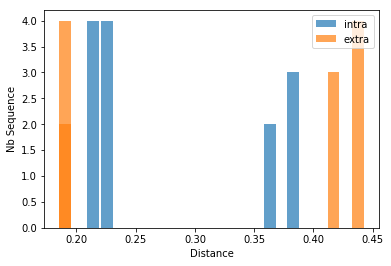

In [8]:
histo(dist_intra, dist_extra)